# Package

In [47]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder,scale
from scipy import stats
import seaborn as sns
import math
import statistics

# Data Loading

In [48]:
data = pd.read_csv('train.csv')
data.tail(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


# Data Preprocessing

## Check and Drop NaN Value

In [49]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [50]:
# drop na
data.dropna(inplace=True)
data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [51]:
# Drop unuseful variable
data.drop(['Name','Ticket'],inplace=True, axis = 1)
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
1,2,1,1,female,38.0,1,0,71.2833,C85,C
3,4,1,1,female,35.0,1,0,53.1000,C123,S
6,7,0,1,male,54.0,0,0,51.8625,E46,S
10,11,1,3,female,4.0,1,1,16.7000,G6,S
11,12,1,1,female,58.0,0,0,26.5500,C103,S


## Encoding

In [52]:
le = LabelEncoder()
le.fit(['male','female'])
data.Sex = le.transform(data.Sex)

data.Cabin = [x[0] for x in data.Cabin.values]
cabin_df= pd.get_dummies(data.Cabin)
embark_df= pd.get_dummies(data.Embarked)
cabin_df.columns = 'Cabin_'+cabin_df.columns
embark_df.columns = 'Embark_'+embark_df.columns

In [53]:
data = data.join([cabin_df,embark_df])

In [54]:
data.drop(['PassengerId','Cabin','Embarked'],axis=1,inplace=True)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embark_C,Embark_Q,Embark_S
1,1,1,0,38.0,1,0,71.2833,0,0,1,0,0,0,0,0,1,0,0
3,1,1,0,35.0,1,0,53.1000,0,0,1,0,0,0,0,0,0,0,1
6,0,1,1,54.0,0,0,51.8625,0,0,0,0,1,0,0,0,0,0,1
10,1,3,0,4.0,1,1,16.7000,0,0,0,0,0,0,1,0,0,0,1
11,1,1,0,58.0,0,0,26.5500,0,0,1,0,0,0,0,0,0,0,1


# Correlation Analysis

In [136]:
# For binary variable
def tetrochoric_corr(v1,v2):
    count=pd.crosstab(v1, v2)
    molecular = math.sqrt(count.iloc[0,1]*count.iloc[1,0])
    denominator = math.sqrt(count.iloc[0,1]*count.iloc[1,0])+math.sqrt(count.iloc[0,0]*count.iloc[1,1])
    rt = math.cos((molecular*math.pi) / denominator)
    return round(rt,2)

In [174]:
class DataCor(object):
    def __init__(self,data):
        self.scale_data = pd.DataFrame(scale(data))
        self.datatype = data
    def corr_matrix(self):
        # create corrlation matrix 
        corr_mat = pd.DataFrame(0, index=self.datatype.columns, columns=self.datatype.columns)
        # Data type identity
        identity = [len(set(self.datatype.iloc[:,x])) for x in np.arange(self.datatype.shape[1])]
        for i in np.arange(len(corr_mat)):
            corr_mat.iloc[i,i] = 1
            
        for i in np.arange(len(corr_mat)):
            for j in np.arange(len(corr_mat)):
                if i == j or i<j:
                    pass
                
                # Identitfy if both data types are binary.
                elif identity[i] == 2 and identity[j] == 2 :
                    corr_mat.iloc[i,j] = tetrochoric_corr(self.scale_data.iloc[:,i],self.scale_data.iloc[:,j])
                    corr_mat.iloc[j,i] = tetrochoric_corr(self.scale_data.iloc[:,i],self.scale_data.iloc[:,j])
               
                # Sujest to use Point-biserial correlation (binary & numeric) but I use pearson in this case. 
                else:
                    corr_mat.iloc[i,j] = stats.pearsonr(self.scale_data.iloc[:,i],self.scale_data.iloc[:,j])[0]
                    corr_mat.iloc[j,i] = stats.pearsonr(self.scale_data.iloc[:,i],self.scale_data.iloc[:,j])[0]
            
        return corr_mat

In [177]:
cor_data = DataCor(data)
corr = cor_data.corr_matrix()

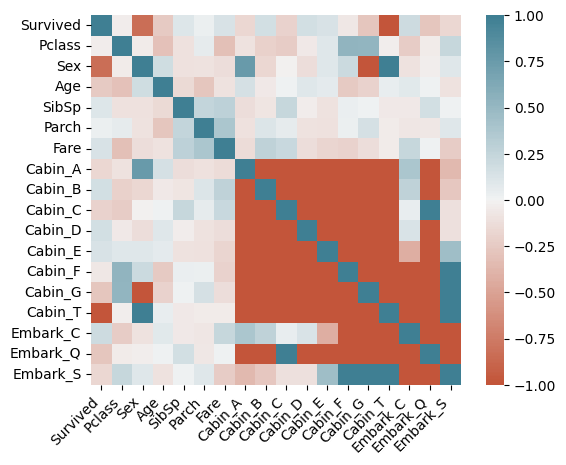

In [178]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);